# DQAN: DQN (Deep Q-Nets) + GAN (Gen. Adv. Nets)

In this notebook, we'll combine a DQN (deep Q-net) with GAN (generative adverserial net) that can learn to play games through reinforcement learning without any reward function. We'll call this network DQAN (deep Q adverserial net). 
Adverserial nets learn to maximize the current reward based the past rewards.
Q-net learns to maximize the future rewards based on the current reward.
Given a task and known when the task is done or failed, we should be able to learn the task.

# DQN
More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[ 0.04927189 -0.16509547  0.04587628  0.34025463] 0 1.0 False {}
state, action, reward, done, info
[0.04596999 0.02934473 0.05268137 0.06238409] 1 1.0 False {}
state, action, reward, done, info
[ 0.04655688  0.22367332  0.05392905 -0.21322324] 1 1.0 False {}
state, action, reward, done, info
[0.05103035 0.02782348 0.04966459 0.09597189] 0 1.0 False {}
state, action, reward, done, info
[ 0.05158682  0.22219973  0.05158402 -0.18063759] 1 1.0 False {}
state, action, reward, done, info
[ 0.05603081  0.41654704  0.04797127 -0.45661181] 1 1.0 False {}
state, action, reward, done, info
[ 0.06436175  0.61095911  0.03883904 -0.73379629] 1 1.0 False {}
state, action, reward, done, info
[ 0.07658093  0.80552354  0.02416311 -1.01400704] 1 1.0 False {}
state, action, reward, done, info
[ 0.0926914   1.00031501  0.00388297 -1.29900569] 1 1.0 False {}
state, action, reward, done, info
[ 0.1126977   1.19538745 -0.02209714 -1.59047056] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.1953874532853495 -1.5904705557941337


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [6]:
def generator(states, state_size, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        return logits

In [7]:
def discriminator(actions, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=True)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=True)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # logits for loss and reward/prob/out
        return logits

In [8]:
def model_loss(states, actions, action_size, hidden_size, state_size, targetQs, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param states: real input states or observations given
    :param actions: real actions given
    :return: A tuple of (discriminator loss, generator loss)
    """
    # The fake/generated actions
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, 
                               state_size=state_size)
    actions_fake = tf.nn.softmax(actions_logits)
    d_logits_fake = discriminator(actions=actions_fake, hidden_size=hidden_size, action_size=action_size)

    # The real onehot encoded actions
    actions_real = tf.one_hot(actions, action_size)
    d_logits_real = discriminator(actions=actions_real, hidden_size=hidden_size, action_size=action_size, 
                                  reuse=True)

    # Training the rewarding function
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Train the generate to maximize the current reward 0-1
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Train the generator to maximize the future rewards: Bellman equations: loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # The generated rewards for Bellman equation
    rewards_fake = tf.sigmoid(d_logits_fake)

    return d_loss, g_loss, q_loss, actions_logits, Qs, rewards_fake

In [9]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations
    :param d_loss: Discriminator/Reward loss Tensor for reward function
    :param g_loss: Generator/Q-value loss Tensor for action & next state predicton
    :param q_loss: Value loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=g_vars)

    return d_opt, g_opt, q_opt

In [10]:
class DQAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.d_loss, self.g_loss, self.q_loss, self.actions_logits, self.Qs, self.rewards_fake = model_loss(
            state_size=state_size, action_size=action_size, actions=self.actions, states=self.states, 
            hidden_size=hidden_size, targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.d_opt, self.g_opt, self.q_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, 
                                                       q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [11]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
train_episodes = 10000          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [13]:
tf.reset_default_graph()
model = DQAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
                 learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [14]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        d_loss, g_loss, q_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            feed_dict={model.states: next_states}
            next_actions_logits, next_rewards_fake = sess.run([model.actions_logits, model.rewards_fake], feed_dict)

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation
            targetQs = next_rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))
            # print('DEBUGGING', targetQs.shape, next_rewards_fake.shape, next_actions_logits.shape, np.max(next_actions_logits, axis=1).shape)

            # Updating the model
            feed_dict = {model.states: states, model.actions: actions, model.targetQs: targetQs}
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/DQAN-cartpole.ckpt')

Episode: 0 Total reward: 5.0 Training d_loss: 1.3833 Training g_loss: 0.6908 Training q_loss: 0.4484 Explore P: 0.9995
Episode: 1 Total reward: 11.0 Training d_loss: 1.3210 Training g_loss: 0.7272 Training q_loss: 0.5769 Explore P: 0.9984
Episode: 2 Total reward: 18.0 Training d_loss: 1.2916 Training g_loss: 0.7359 Training q_loss: 0.7180 Explore P: 0.9966
Episode: 3 Total reward: 16.0 Training d_loss: 1.3150 Training g_loss: 0.7188 Training q_loss: 11.8993 Explore P: 0.9951
Episode: 4 Total reward: 17.0 Training d_loss: 1.3380 Training g_loss: 0.7390 Training q_loss: 21.0891 Explore P: 0.9934
Episode: 5 Total reward: 13.0 Training d_loss: 1.3244 Training g_loss: 0.7499 Training q_loss: 9.3055 Explore P: 0.9921
Episode: 6 Total reward: 36.0 Training d_loss: 1.4197 Training g_loss: 0.7101 Training q_loss: 20.7287 Explore P: 0.9886
Episode: 7 Total reward: 30.0 Training d_loss: 1.3510 Training g_loss: 0.7109 Training q_loss: 131.2267 Explore P: 0.9857
Episode: 8 Total reward: 19.0 Traini

Episode: 68 Total reward: 20.0 Training d_loss: 1.3751 Training g_loss: 0.7162 Training q_loss: 340.5836 Explore P: 0.8818
Episode: 69 Total reward: 12.0 Training d_loss: 1.3858 Training g_loss: 0.6911 Training q_loss: 144.7510 Explore P: 0.8808
Episode: 70 Total reward: 13.0 Training d_loss: 1.2977 Training g_loss: 0.8421 Training q_loss: 745.6630 Explore P: 0.8797
Episode: 71 Total reward: 42.0 Training d_loss: 1.3601 Training g_loss: 0.6778 Training q_loss: 111.8519 Explore P: 0.8760
Episode: 72 Total reward: 11.0 Training d_loss: 1.3719 Training g_loss: 0.7571 Training q_loss: 1354.4993 Explore P: 0.8751
Episode: 73 Total reward: 11.0 Training d_loss: 1.3401 Training g_loss: 0.6762 Training q_loss: 329.9167 Explore P: 0.8741
Episode: 74 Total reward: 19.0 Training d_loss: 1.3680 Training g_loss: 0.7083 Training q_loss: 38.9823 Explore P: 0.8725
Episode: 75 Total reward: 10.0 Training d_loss: 1.3751 Training g_loss: 0.7414 Training q_loss: 96.1714 Explore P: 0.8716
Episode: 76 Total

Episode: 136 Total reward: 11.0 Training d_loss: 1.4022 Training g_loss: 0.6617 Training q_loss: 51.6485 Explore P: 0.7772
Episode: 137 Total reward: 14.0 Training d_loss: 1.2939 Training g_loss: 0.7662 Training q_loss: 186.9707 Explore P: 0.7761
Episode: 138 Total reward: 14.0 Training d_loss: 1.2858 Training g_loss: 0.7998 Training q_loss: 285.2490 Explore P: 0.7750
Episode: 139 Total reward: 7.0 Training d_loss: 1.3211 Training g_loss: 0.7278 Training q_loss: 56.3159 Explore P: 0.7745
Episode: 140 Total reward: 11.0 Training d_loss: 1.3320 Training g_loss: 0.7269 Training q_loss: 43.0059 Explore P: 0.7736
Episode: 141 Total reward: 16.0 Training d_loss: 1.3691 Training g_loss: 0.7202 Training q_loss: 393.9413 Explore P: 0.7724
Episode: 142 Total reward: 16.0 Training d_loss: 1.2994 Training g_loss: 0.7841 Training q_loss: 40.6820 Explore P: 0.7712
Episode: 143 Total reward: 14.0 Training d_loss: 1.4167 Training g_loss: 0.6269 Training q_loss: 28.5200 Explore P: 0.7701
Episode: 144 T

Episode: 203 Total reward: 11.0 Training d_loss: 1.3726 Training g_loss: 0.7745 Training q_loss: 486.2225 Explore P: 0.7052
Episode: 204 Total reward: 22.0 Training d_loss: 1.5866 Training g_loss: 0.6409 Training q_loss: 74.7727 Explore P: 0.7037
Episode: 205 Total reward: 12.0 Training d_loss: 1.4324 Training g_loss: 0.6867 Training q_loss: 194.8629 Explore P: 0.7028
Episode: 206 Total reward: 12.0 Training d_loss: 1.3198 Training g_loss: 0.8075 Training q_loss: 61.0977 Explore P: 0.7020
Episode: 207 Total reward: 14.0 Training d_loss: 1.2825 Training g_loss: 0.8109 Training q_loss: 418.8892 Explore P: 0.7010
Episode: 208 Total reward: 19.0 Training d_loss: 1.2916 Training g_loss: 1.1356 Training q_loss: 195.9589 Explore P: 0.6997
Episode: 209 Total reward: 23.0 Training d_loss: 1.3164 Training g_loss: 0.7454 Training q_loss: 224.4086 Explore P: 0.6981
Episode: 210 Total reward: 10.0 Training d_loss: 1.2726 Training g_loss: 1.2188 Training q_loss: 42.7640 Explore P: 0.6975
Episode: 21

Episode: 270 Total reward: 12.0 Training d_loss: 1.3034 Training g_loss: 0.7658 Training q_loss: 434.2135 Explore P: 0.6475
Episode: 271 Total reward: 12.0 Training d_loss: 1.1917 Training g_loss: 0.7512 Training q_loss: 302.0523 Explore P: 0.6468
Episode: 272 Total reward: 8.0 Training d_loss: 1.4075 Training g_loss: 0.7362 Training q_loss: 828.5851 Explore P: 0.6463
Episode: 273 Total reward: 11.0 Training d_loss: 1.3670 Training g_loss: 0.7358 Training q_loss: 469.7834 Explore P: 0.6456
Episode: 274 Total reward: 13.0 Training d_loss: 1.2270 Training g_loss: 1.0970 Training q_loss: 77.3025 Explore P: 0.6447
Episode: 275 Total reward: 11.0 Training d_loss: 1.2459 Training g_loss: 0.7749 Training q_loss: 133.3771 Explore P: 0.6440
Episode: 276 Total reward: 11.0 Training d_loss: 1.3437 Training g_loss: 0.6714 Training q_loss: 180.9232 Explore P: 0.6433
Episode: 277 Total reward: 8.0 Training d_loss: 1.3015 Training g_loss: 0.8299 Training q_loss: 229.8957 Explore P: 0.6428
Episode: 27

Episode: 337 Total reward: 11.0 Training d_loss: 1.1242 Training g_loss: 2.0326 Training q_loss: 273.3051 Explore P: 0.5926
Episode: 338 Total reward: 14.0 Training d_loss: 1.4564 Training g_loss: 0.8446 Training q_loss: 97.3049 Explore P: 0.5918
Episode: 339 Total reward: 10.0 Training d_loss: 1.3727 Training g_loss: 0.7367 Training q_loss: 621.2433 Explore P: 0.5912
Episode: 340 Total reward: 11.0 Training d_loss: 1.2476 Training g_loss: 1.0888 Training q_loss: 133.5849 Explore P: 0.5906
Episode: 341 Total reward: 9.0 Training d_loss: 1.1744 Training g_loss: 1.0351 Training q_loss: 921.8209 Explore P: 0.5900
Episode: 342 Total reward: 11.0 Training d_loss: 1.2870 Training g_loss: 1.4374 Training q_loss: 365.9849 Explore P: 0.5894
Episode: 343 Total reward: 12.0 Training d_loss: 1.3232 Training g_loss: 1.2081 Training q_loss: 436.7523 Explore P: 0.5887
Episode: 344 Total reward: 13.0 Training d_loss: 1.2916 Training g_loss: 1.4153 Training q_loss: 609.4051 Explore P: 0.5880
Episode: 3

Episode: 404 Total reward: 36.0 Training d_loss: 1.3812 Training g_loss: 0.6790 Training q_loss: 8405.8672 Explore P: 0.4747
Episode: 405 Total reward: 36.0 Training d_loss: 1.3114 Training g_loss: 1.2626 Training q_loss: 136.2239 Explore P: 0.4730
Episode: 406 Total reward: 79.0 Training d_loss: 1.3318 Training g_loss: 0.7845 Training q_loss: 98.0696 Explore P: 0.4693
Episode: 407 Total reward: 44.0 Training d_loss: 1.3340 Training g_loss: 1.2170 Training q_loss: 496.9256 Explore P: 0.4673
Episode: 408 Total reward: 41.0 Training d_loss: 1.3125 Training g_loss: 0.9816 Training q_loss: 13714.3379 Explore P: 0.4655
Episode: 409 Total reward: 114.0 Training d_loss: 1.3869 Training g_loss: 0.7091 Training q_loss: 277.6996 Explore P: 0.4603
Episode: 410 Total reward: 55.0 Training d_loss: 1.2908 Training g_loss: 0.7344 Training q_loss: 1037.8671 Explore P: 0.4578
Episode: 411 Total reward: 57.0 Training d_loss: 1.2983 Training g_loss: 0.8333 Training q_loss: 11884.1377 Explore P: 0.4553
Ep

Episode: 470 Total reward: 156.0 Training d_loss: 1.3488 Training g_loss: 0.9760 Training q_loss: 185.9607 Explore P: 0.2617
Episode: 471 Total reward: 126.0 Training d_loss: 1.3308 Training g_loss: 1.0119 Training q_loss: 27093.0098 Explore P: 0.2586
Episode: 472 Total reward: 118.0 Training d_loss: 1.2361 Training g_loss: 1.5312 Training q_loss: 210.3831 Explore P: 0.2557
Episode: 473 Total reward: 147.0 Training d_loss: 1.2876 Training g_loss: 1.1002 Training q_loss: 314.4809 Explore P: 0.2521
Episode: 474 Total reward: 128.0 Training d_loss: 1.3506 Training g_loss: 1.0144 Training q_loss: 143.8987 Explore P: 0.2490
Episode: 475 Total reward: 111.0 Training d_loss: 1.1530 Training g_loss: 1.8825 Training q_loss: 329.9439 Explore P: 0.2464
Episode: 476 Total reward: 170.0 Training d_loss: 1.2750 Training g_loss: 1.2443 Training q_loss: 2261.5215 Explore P: 0.2424
Episode: 477 Total reward: 88.0 Training d_loss: 1.3299 Training g_loss: 0.7006 Training q_loss: 210.1850 Explore P: 0.240

Episode: 536 Total reward: 199.0 Training d_loss: 1.1103 Training g_loss: 2.1297 Training q_loss: 101.4651 Explore P: 0.0973
Episode: 537 Total reward: 199.0 Training d_loss: 1.3935 Training g_loss: 0.6333 Training q_loss: 165.8692 Explore P: 0.0956
Episode: 538 Total reward: 199.0 Training d_loss: 1.2641 Training g_loss: 1.3501 Training q_loss: 67.6437 Explore P: 0.0939
Episode: 539 Total reward: 199.0 Training d_loss: 1.1728 Training g_loss: 3.3100 Training q_loss: 80.3692 Explore P: 0.0922
Episode: 540 Total reward: 180.0 Training d_loss: 1.3041 Training g_loss: 0.7389 Training q_loss: 120.6795 Explore P: 0.0908
Episode: 541 Total reward: 199.0 Training d_loss: 1.3844 Training g_loss: 0.7616 Training q_loss: 5114.8657 Explore P: 0.0892
Episode: 542 Total reward: 199.0 Training d_loss: 1.0635 Training g_loss: 1.9119 Training q_loss: 48.6772 Explore P: 0.0876
Episode: 543 Total reward: 199.0 Training d_loss: 0.9940 Training g_loss: 0.8650 Training q_loss: 59.0351 Explore P: 0.0861
Epi

Episode: 602 Total reward: 199.0 Training d_loss: 1.1417 Training g_loss: 4.8445 Training q_loss: 59.4141 Explore P: 0.0346
Episode: 603 Total reward: 199.0 Training d_loss: 1.0005 Training g_loss: 7.8861 Training q_loss: 18.5736 Explore P: 0.0341
Episode: 604 Total reward: 154.0 Training d_loss: 0.9947 Training g_loss: 6.8075 Training q_loss: 496.4303 Explore P: 0.0337
Episode: 605 Total reward: 132.0 Training d_loss: 1.0071 Training g_loss: 9.1807 Training q_loss: 12.7065 Explore P: 0.0334
Episode: 606 Total reward: 122.0 Training d_loss: 1.1873 Training g_loss: 3.9004 Training q_loss: 113.6753 Explore P: 0.0331
Episode: 607 Total reward: 147.0 Training d_loss: 1.2106 Training g_loss: 4.3631 Training q_loss: 39.1052 Explore P: 0.0328
Episode: 608 Total reward: 199.0 Training d_loss: 1.1379 Training g_loss: 2.7327 Training q_loss: 32.5631 Explore P: 0.0324
Episode: 609 Total reward: 169.0 Training d_loss: 1.1608 Training g_loss: 3.8754 Training q_loss: 9.6615 Explore P: 0.0320
Episode

Episode: 669 Total reward: 141.0 Training d_loss: 1.2576 Training g_loss: 3.8504 Training q_loss: 25.4310 Explore P: 0.0184
Episode: 670 Total reward: 124.0 Training d_loss: 1.1998 Training g_loss: 3.1058 Training q_loss: 26.7145 Explore P: 0.0183
Episode: 671 Total reward: 156.0 Training d_loss: 1.2489 Training g_loss: 2.1789 Training q_loss: 7.0658 Explore P: 0.0181
Episode: 672 Total reward: 131.0 Training d_loss: 1.2397 Training g_loss: 7.1150 Training q_loss: 7.8603 Explore P: 0.0180
Episode: 673 Total reward: 199.0 Training d_loss: 1.3382 Training g_loss: 3.6245 Training q_loss: 6.8296 Explore P: 0.0179
Episode: 674 Total reward: 154.0 Training d_loss: 1.3960 Training g_loss: 0.5900 Training q_loss: 16.1414 Explore P: 0.0177
Episode: 675 Total reward: 114.0 Training d_loss: 1.1609 Training g_loss: 1.4123 Training q_loss: 214.1792 Explore P: 0.0177
Episode: 676 Total reward: 114.0 Training d_loss: 1.2233 Training g_loss: 7.0952 Training q_loss: 5.0008 Explore P: 0.0176
Episode: 67

Episode: 736 Total reward: 129.0 Training d_loss: 1.2201 Training g_loss: 4.8480 Training q_loss: 17.7207 Explore P: 0.0131
Episode: 737 Total reward: 134.0 Training d_loss: 1.3999 Training g_loss: 0.5751 Training q_loss: 3.4791 Explore P: 0.0131
Episode: 738 Total reward: 176.0 Training d_loss: 1.2578 Training g_loss: 0.9663 Training q_loss: 5.7083 Explore P: 0.0130
Episode: 739 Total reward: 130.0 Training d_loss: 1.2975 Training g_loss: 4.6266 Training q_loss: 6.6949 Explore P: 0.0130
Episode: 740 Total reward: 123.0 Training d_loss: 1.2184 Training g_loss: 7.1523 Training q_loss: 3.6122 Explore P: 0.0130
Episode: 741 Total reward: 166.0 Training d_loss: 1.2354 Training g_loss: 7.4684 Training q_loss: 2.1057 Explore P: 0.0129
Episode: 742 Total reward: 134.0 Training d_loss: 1.2647 Training g_loss: 3.8131 Training q_loss: 17.9538 Explore P: 0.0129
Episode: 743 Total reward: 108.0 Training d_loss: 1.1425 Training g_loss: 2.5325 Training q_loss: 9.6285 Explore P: 0.0128
Episode: 744 T

Episode: 803 Total reward: 121.0 Training d_loss: 1.3164 Training g_loss: 4.7112 Training q_loss: 1.1690 Explore P: 0.0112
Episode: 804 Total reward: 135.0 Training d_loss: 1.2789 Training g_loss: 0.9867 Training q_loss: 3.5331 Explore P: 0.0112
Episode: 805 Total reward: 126.0 Training d_loss: 1.2074 Training g_loss: 8.3577 Training q_loss: 41.8479 Explore P: 0.0112
Episode: 806 Total reward: 116.0 Training d_loss: 1.2157 Training g_loss: 5.3935 Training q_loss: 11.8938 Explore P: 0.0112
Episode: 807 Total reward: 106.0 Training d_loss: 1.2937 Training g_loss: 1.3856 Training q_loss: 22.5064 Explore P: 0.0112
Episode: 808 Total reward: 107.0 Training d_loss: 1.3180 Training g_loss: 4.7857 Training q_loss: 0.9681 Explore P: 0.0112
Episode: 809 Total reward: 161.0 Training d_loss: 1.2071 Training g_loss: 3.9218 Training q_loss: 8.7628 Explore P: 0.0111
Episode: 810 Total reward: 118.0 Training d_loss: 1.3280 Training g_loss: 0.7742 Training q_loss: 9.4128 Explore P: 0.0111
Episode: 811 

Episode: 870 Total reward: 105.0 Training d_loss: 1.2992 Training g_loss: 0.6999 Training q_loss: 4.2955 Explore P: 0.0105
Episode: 871 Total reward: 108.0 Training d_loss: 1.2086 Training g_loss: 7.1506 Training q_loss: 3.5107 Explore P: 0.0105
Episode: 872 Total reward: 122.0 Training d_loss: 1.2776 Training g_loss: 5.8613 Training q_loss: 14.4203 Explore P: 0.0105
Episode: 873 Total reward: 98.0 Training d_loss: 1.3884 Training g_loss: 0.6693 Training q_loss: 4.4848 Explore P: 0.0105
Episode: 874 Total reward: 100.0 Training d_loss: 1.3076 Training g_loss: 1.0749 Training q_loss: 4.2003 Explore P: 0.0105
Episode: 875 Total reward: 117.0 Training d_loss: 1.3747 Training g_loss: 0.6498 Training q_loss: 5.9207 Explore P: 0.0105
Episode: 876 Total reward: 112.0 Training d_loss: 1.3553 Training g_loss: 0.9457 Training q_loss: 6.6097 Explore P: 0.0105
Episode: 877 Total reward: 150.0 Training d_loss: 1.3138 Training g_loss: 0.6858 Training q_loss: 4.1283 Explore P: 0.0105
Episode: 878 Tot

Episode: 937 Total reward: 113.0 Training d_loss: 1.3020 Training g_loss: 5.6251 Training q_loss: 10.8872 Explore P: 0.0102
Episode: 938 Total reward: 126.0 Training d_loss: 1.2046 Training g_loss: 10.5102 Training q_loss: 26.0442 Explore P: 0.0102
Episode: 939 Total reward: 137.0 Training d_loss: 1.3655 Training g_loss: 0.7702 Training q_loss: 2.1793 Explore P: 0.0102
Episode: 940 Total reward: 93.0 Training d_loss: 1.3543 Training g_loss: 3.1239 Training q_loss: 14.8073 Explore P: 0.0102
Episode: 941 Total reward: 132.0 Training d_loss: 1.3761 Training g_loss: 0.6342 Training q_loss: 10.6041 Explore P: 0.0102
Episode: 942 Total reward: 104.0 Training d_loss: 1.4014 Training g_loss: 0.6629 Training q_loss: 1.7938 Explore P: 0.0102
Episode: 943 Total reward: 156.0 Training d_loss: 1.3898 Training g_loss: 0.7469 Training q_loss: 6.9583 Explore P: 0.0102
Episode: 944 Total reward: 141.0 Training d_loss: 1.1615 Training g_loss: 10.5305 Training q_loss: 7.3358 Explore P: 0.0102
Episode: 94

Episode: 1004 Total reward: 139.0 Training d_loss: 1.3437 Training g_loss: 0.8085 Training q_loss: 9.7786 Explore P: 0.0101
Episode: 1005 Total reward: 108.0 Training d_loss: 1.3390 Training g_loss: 4.9436 Training q_loss: 28.5963 Explore P: 0.0101
Episode: 1006 Total reward: 115.0 Training d_loss: 1.3927 Training g_loss: 0.6917 Training q_loss: 20.7806 Explore P: 0.0101
Episode: 1007 Total reward: 110.0 Training d_loss: 1.3938 Training g_loss: 0.6662 Training q_loss: 11.4800 Explore P: 0.0101
Episode: 1008 Total reward: 116.0 Training d_loss: 1.4335 Training g_loss: 0.5900 Training q_loss: 3.4780 Explore P: 0.0101
Episode: 1009 Total reward: 99.0 Training d_loss: 1.3058 Training g_loss: 0.9623 Training q_loss: 8.5772 Explore P: 0.0101
Episode: 1010 Total reward: 111.0 Training d_loss: 1.4145 Training g_loss: 0.5728 Training q_loss: 24.1208 Explore P: 0.0101
Episode: 1011 Total reward: 131.0 Training d_loss: 1.3347 Training g_loss: 1.4084 Training q_loss: 2.0435 Explore P: 0.0101
Episo

Episode: 1071 Total reward: 98.0 Training d_loss: 1.3975 Training g_loss: 0.6216 Training q_loss: 15.0516 Explore P: 0.0100
Episode: 1072 Total reward: 145.0 Training d_loss: 1.4176 Training g_loss: 0.5093 Training q_loss: 39.7792 Explore P: 0.0100
Episode: 1073 Total reward: 145.0 Training d_loss: 1.4309 Training g_loss: 0.5786 Training q_loss: 109.3918 Explore P: 0.0100
Episode: 1074 Total reward: 111.0 Training d_loss: 1.2434 Training g_loss: 1.1640 Training q_loss: 3.1555 Explore P: 0.0100
Episode: 1075 Total reward: 104.0 Training d_loss: 1.3794 Training g_loss: 0.6701 Training q_loss: 87.8711 Explore P: 0.0100
Episode: 1076 Total reward: 114.0 Training d_loss: 1.3867 Training g_loss: 0.7156 Training q_loss: 8.7189 Explore P: 0.0100
Episode: 1077 Total reward: 110.0 Training d_loss: 1.3299 Training g_loss: 0.7577 Training q_loss: 8.1297 Explore P: 0.0100
Episode: 1078 Total reward: 133.0 Training d_loss: 1.3862 Training g_loss: 0.7084 Training q_loss: 3.3987 Explore P: 0.0100
Epis

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

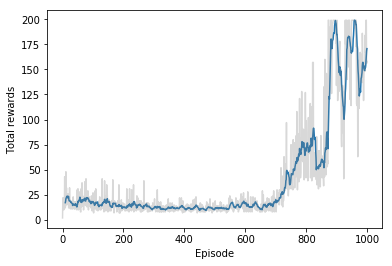

In [24]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'D losses')

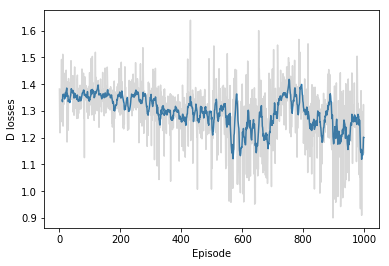

In [19]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'G losses')

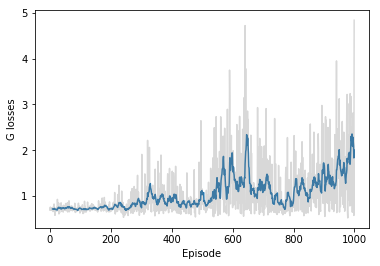

In [22]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'Q losses')

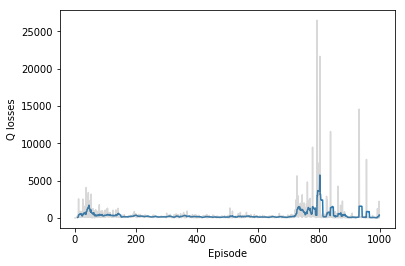

In [23]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [25]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Save the trained model 
    saver.restore(sess, 'checkpoints/DQAN-cartpole.ckpt')
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/DQAN-cartpole.ckpt


In [26]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.